<h1>Import Libraries and Datasets</h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime


import folium
from folium.plugins import HeatMap

import re
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator

In [2]:
listings_raw = pd.read_csv(r"C:\Users\asus\Documents\DA\Project\listings.csv")
calendar_raw = pd.read_csv(r"C:\Users\asus\Documents\DA\Project\calendar.csv")
reviews_raw = pd.read_csv(r"C:\Users\asus\Documents\DA\Project\reviews.csv")

<h1>Data Cleaning and Preparation</h1>

In [3]:
'''
listings_raw.columns.values
listings_raw.isnull().sum()
listings_raw.info()
'''

'\nlistings_raw.columns.values\nlistings_raw.isnull().sum()\nlistings_raw.info()\n'

In [4]:
# DataFrame for Listings
df = listings_raw.loc[:,['id', 'name', 'description', 'host_id', 'host_is_superhost', 'host_has_profile_pic',
                         'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
                         'latitude', 'longitude', 'property_type', 'room_type', 'minimum_nights',
                         'amenities', 'price', 'number_of_reviews', 'review_scores_rating', 'instant_bookable']]


# Data Cleaning
df.loc[:, 'id'] = df['id'].astype(str) # Change id to String
df.loc[:, 'host_id'] = df['host_id'].astype(str) # Change host_id to String
df.loc[:,'price'] = df['price'].str.strip('$').str.replace(",", "").astype(float)
df.drop(df.loc[df['price']==0].index, inplace=True)

# Change the t-f values into boolean
df.host_is_superhost = df.host_is_superhost.replace({'f': False, 't': True}) 
df.host_has_profile_pic = df.host_has_profile_pic.replace({'f': False, 't': True})
df.host_identity_verified = df.host_identity_verified.replace({'f': False, 't': True})
df.instant_bookable = df.instant_bookable.replace({'f': False, 't': True})

df.duplicated().sum()
df.drop_duplicates(inplace=True)

In [5]:
calendar_raw.loc[:, 'listing_id'] = calendar_raw['listing_id'].astype(str) # Change id to String
df_cal = pd.merge(calendar_raw, df, how='left', left_on='listing_id', right_on='id')
df_cal.loc[:,'adjusted_price'] = df_cal['adjusted_price'].str.strip('$').str.replace(",", "").astype(float)
df_cal = df_cal.loc[:,['date', 'id', 'adjusted_price']]

df_cal.loc[:, 'date'] = pd.to_datetime(df_cal['date'])
df_cal['year'] = pd.DatetimeIndex(df_cal['date']).year
df_cal['month'] = pd.DatetimeIndex(df_cal['date']).month
df_cal['monthname'] = pd.DatetimeIndex(df_cal['date']).month_name()
df_cal['dayofmonth'] = pd.DatetimeIndex(df_cal['date']).day
df_cal['dayofweekname'] = pd.DatetimeIndex(df_cal['date']).day_name()


In [6]:
df_rev = reviews_raw.loc[:,['listing_id', 'id', 'date']]
df_rev.loc[:, 'date'] = pd.to_datetime(df_rev['date'])
df_rev['year'] = pd.DatetimeIndex(df_rev['date']).year
df_rev['month'] = pd.DatetimeIndex(df_rev['date']).month
df_rev['monthname'] = pd.DatetimeIndex(df_rev['date']).month_name()
df_rev['dayofmonth'] = pd.DatetimeIndex(df_rev['date']).day
df_rev['dayofweekname'] = pd.DatetimeIndex(df_rev['date']).day_name()



# Price Distribution

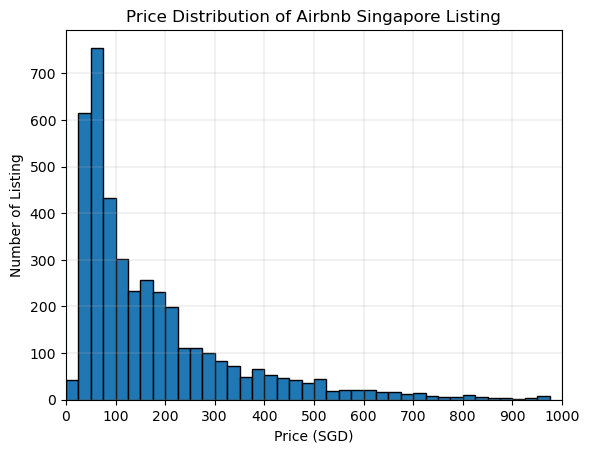

In [7]:
plt.hist(df['price'], bins=np.arange(0,1000,25), edgecolor='black')
plt.title('Price Distribution of Airbnb Singapore Listing')
plt.xlabel('Price (SGD)')
plt.ylabel('Number of Listing')
plt.xlim(0,1000) 
plt.xticks(range(0,1100,100))
plt.grid(linewidth=0.25)
plt.show()


In [8]:
df['price'].agg(['count', 'mean', 'median', 'min', 'max'])


count      4160.000000
mean        214.556731
median      120.000000
min          13.000000
max       12494.000000
Name: price, dtype: float64

# Neighbourhood Price Distribution

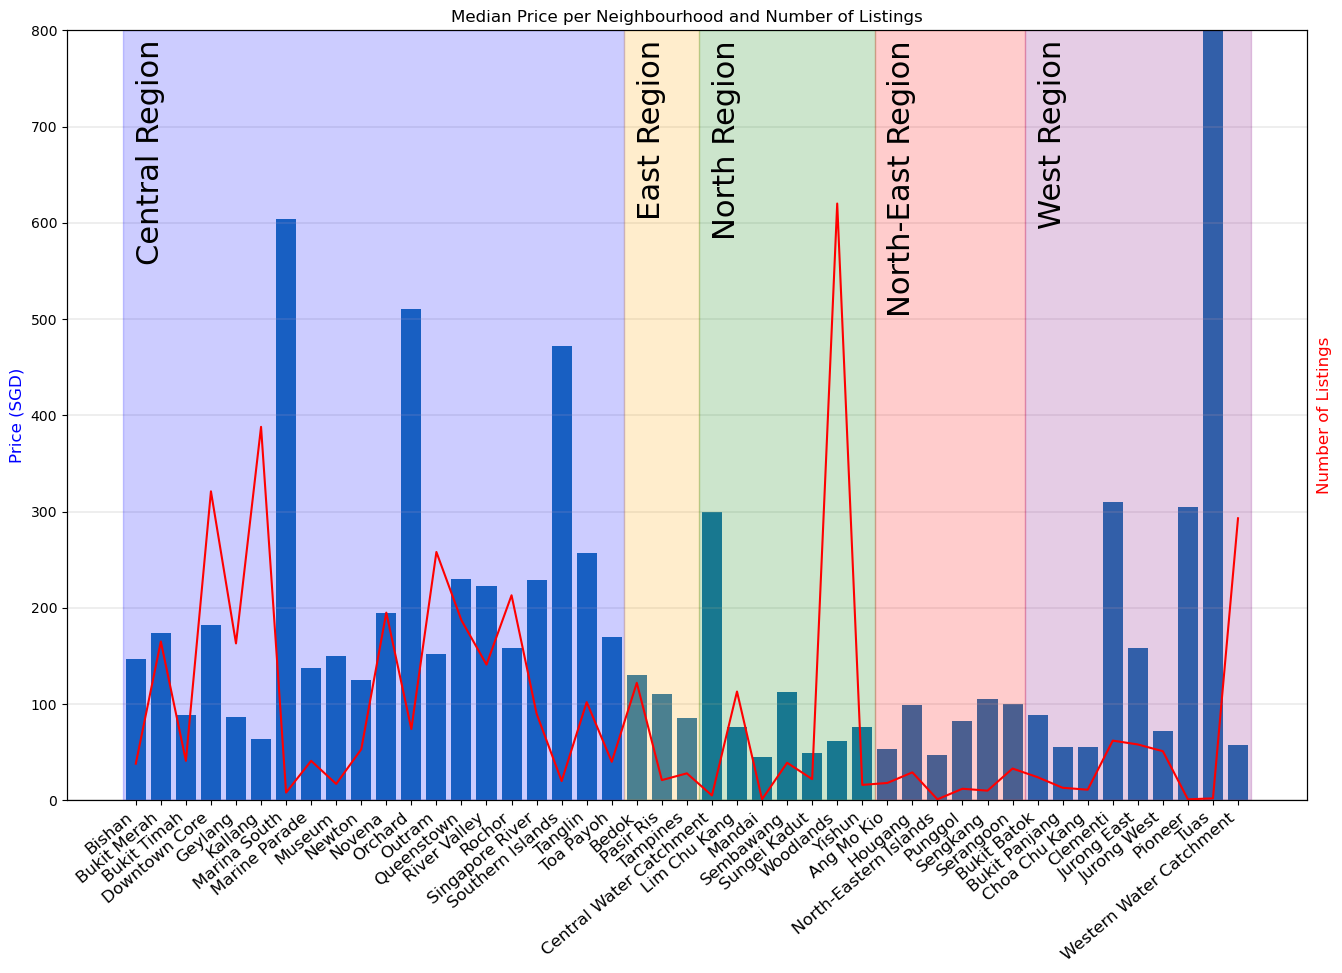

In [9]:
neighbourhood = df.groupby(['neighbourhood_group_cleansed', 'neighbourhood_cleansed'])['price'].agg(['count', 'median']).reset_index()
fig, ax1 = plt.subplots(figsize=(16, 10))
ax2 = ax1.twinx()
ax1.bar(neighbourhood['neighbourhood_cleansed'], neighbourhood['median'])
ax2.plot(neighbourhood['neighbourhood_cleansed'], neighbourhood['count'], color='red')

plt.title('Median Price per Neighbourhood and Number of Listings')
plt.xlabel('')
ax1.set_ylabel('Price (SGD)', color = 'blue', fontsize=12)
ax2.set_ylabel('Number of Listings', color = 'red', fontsize=12)
ax1.set_ylim(0, 800)
ax2.set_ylim(0, 800)
ax1.grid(linewidth=0.30, axis='y')
ax2.set_yticks([]) 
plt.setp(ax1.get_xticklabels(), fontsize=12, rotation=40, 
         horizontalalignment="right")

plt.axvspan(-0.5, 19.5, color='blue', alpha=0.2)
plt.text(0, 790, "Central Region", va = 'top', rotation = 90, fontsize = 22)
plt.axvspan(19.5, 22.5, color='orange', alpha=0.2)
plt.text(20, 790, "East Region", va = 'top', rotation = 90, fontsize = 22)
plt.axvspan(22.5, 29.5, color='green', alpha=0.2)
plt.text(23, 790, "North Region", va = 'top', rotation = 90, fontsize = 22)
plt.axvspan(29.5, 35.5, color='red', alpha=0.2)
plt.text(30, 790, "North-East Region", va = 'top', rotation = 90, fontsize = 22)
plt.axvspan(35.5, 44.5, color='purple', alpha=0.2)
plt.text(36, 790, "West Region", va = 'top', rotation = 90, fontsize = 22)
plt.show()

# Region Analysis

In [10]:
roomtypes=df.groupby(['neighbourhood_group_cleansed', 'room_type'], as_index=False).size()
roomtypes['region']='Region'
roomtypes['neighbourhood_group_cleansed'] = roomtypes['neighbourhood_group_cleansed'].str.rstrip(' Region')
display(roomtypes)

neighbourhood_group_cleansed        room_type  size  region
0                       Central  Entire home/apt  1222  Region
1                       Central       Hotel room   132  Region
2                       Central     Private room  1093  Region
3                       Central      Shared room   108  Region
4                          East  Entire home/apt    34  Region
5                          East     Private room   133  Region
6                          East      Shared room     4  Region
7                         North  Entire home/apt   656  Region
8                         North       Hotel room    11  Region
9                         North     Private room   145  Region
10                        North      Shared room     4  Region
11                   North-East  Entire home/apt    28  Region
12                   North-East     Private room    72  Region
13                   North-East      Shared room     3  Region
14                         West  Entire home/apt   390  Region
15                         West     Private room   124  Region
16                         West      Shared room     1  Region

In [11]:
import plotly.graph_objects as go
import plotly.express as px
fig = px.sunburst(roomtypes, path=['region', 'neighbourhood_group_cleansed', 'room_type'], values='size')
fig.add_trace(go.Sunburst(maxdepth=2, insidetextorientation= 'horizontal'))
fig.update_traces(textinfo="label+percent parent")
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0))
fig.show()

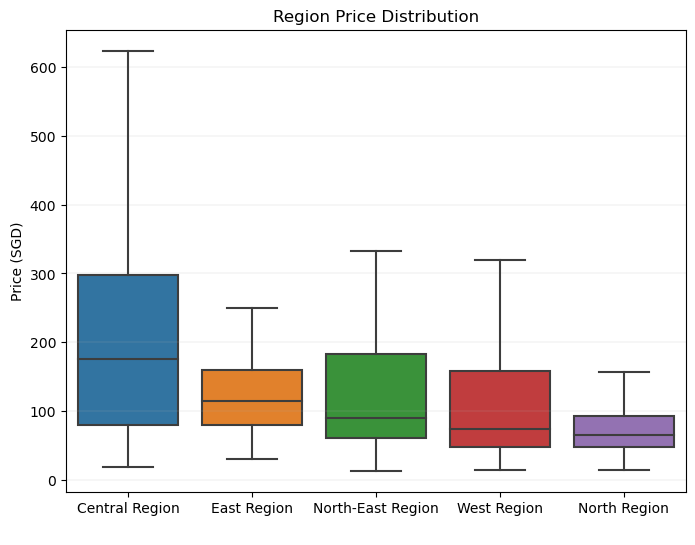

In [8]:
plt.figure(figsize=(8,6))
sns.boxplot(x='neighbourhood_group_cleansed', y='price', data = df, showfliers = False)
plt.title('Region Price Distribution')
plt.xlabel(' ')
plt.ylabel('Price (SGD)')
plt.grid(linewidth=0.15, axis='y')
plt.show()

In [76]:
df.groupby('neighbourhood_group_cleansed')['price'].median()

neighbourhood_group_cleansed
Central Region       175.0
East Region          115.0
North Region          65.0
North-East Region     90.0
West Region           74.0
Name: price, dtype: float64

In [13]:
heatmap = folium.Map([1.35000,103.8350],zoom_start=12)
HeatMap(df[['latitude','longitude']].dropna(),radius=8,gradient={0.2:'blue',0.4:'purple',0.6:'orange',1.0:'red'}).add_to(heatmap)
display(heatmap)

# Room Type

In [71]:
df.groupby(['neighbourhood_group_cleansed', 'room_type']).size()

neighbourhood_group_cleansed  room_type      
Central Region                Entire home/apt    1222
                              Hotel room          132
                              Private room       1093
                              Shared room         108
East Region                   Entire home/apt      34
                              Private room        133
                              Shared room           4
North Region                  Entire home/apt     656
                              Hotel room           11
                              Private room        145
                              Shared room           4
North-East Region             Entire home/apt      28
                              Private room         72
                              Shared room           3
West Region                   Entire home/apt     390
                              Private room        124
                              Shared room           1
dtype: int64

(array([0, 1, 2, 3]),
 [Text(0, 0, 'Entire home/apt'),
  Text(1, 0, 'Private room'),
  Text(2, 0, 'Hotel room'),
  Text(3, 0, 'Shared room')])

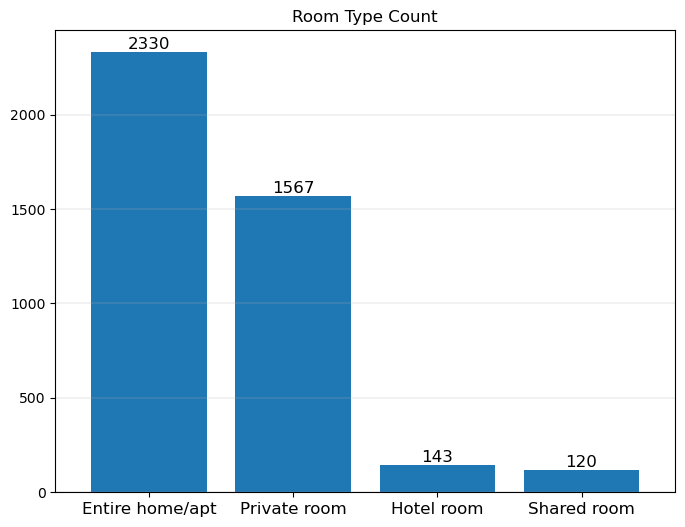

In [16]:
rt = df.groupby('room_type').size().sort_values(ascending=False)
rt.plot(kind="bar", width=0.8, figsize=(8,6))
plt.grid(linewidth=0.25, axis='y')
for i, (p, pr) in enumerate(zip(rt.index, rt.values)):
    plt.text(s=str(pr), x=i, y=pr+40, color="k",
             verticalalignment="center", horizontalalignment="center", size=12)


plt.title('Room Type Count')
plt.axis()
plt.xlabel('')
plt.xticks(rotation=0, fontsize='12', horizontalalignment='center')

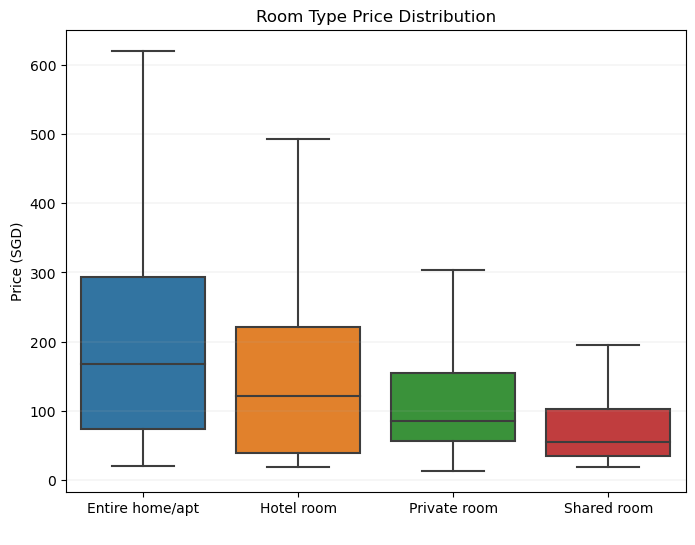

In [211]:
plt.figure(figsize=(8,6))
sns.boxplot(x='room_type', y='price', data = df, showfliers = False, 
            order=["Entire home/apt", "Hotel room", "Private room", "Shared room"])
plt.title('Room Type Price Distribution')
plt.xlabel(' ')
plt.ylabel('Price (SGD)')
plt.grid(linewidth=0.15, axis='y')
plt.show()

In [79]:
df['property_type'] = df['property_type'].str.lower()
df['property_type'] = df['property_type'].str.replace('entire ','')
df['property_type'] = df['property_type'].str.replace('private ','')
df['property_type'] = df['property_type'].str.replace('shared ','')
df['property_type'] = df['property_type'].str.replace('room in ','')
df['property_type'] = df['property_type'].str.replace('houseboat','boat')

(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'Entire home/apt'),
  Text(1.5, 0, 'Private room'),
  Text(2.5, 0, 'Hotel room'),
  Text(3.5, 0, 'Shared room')])

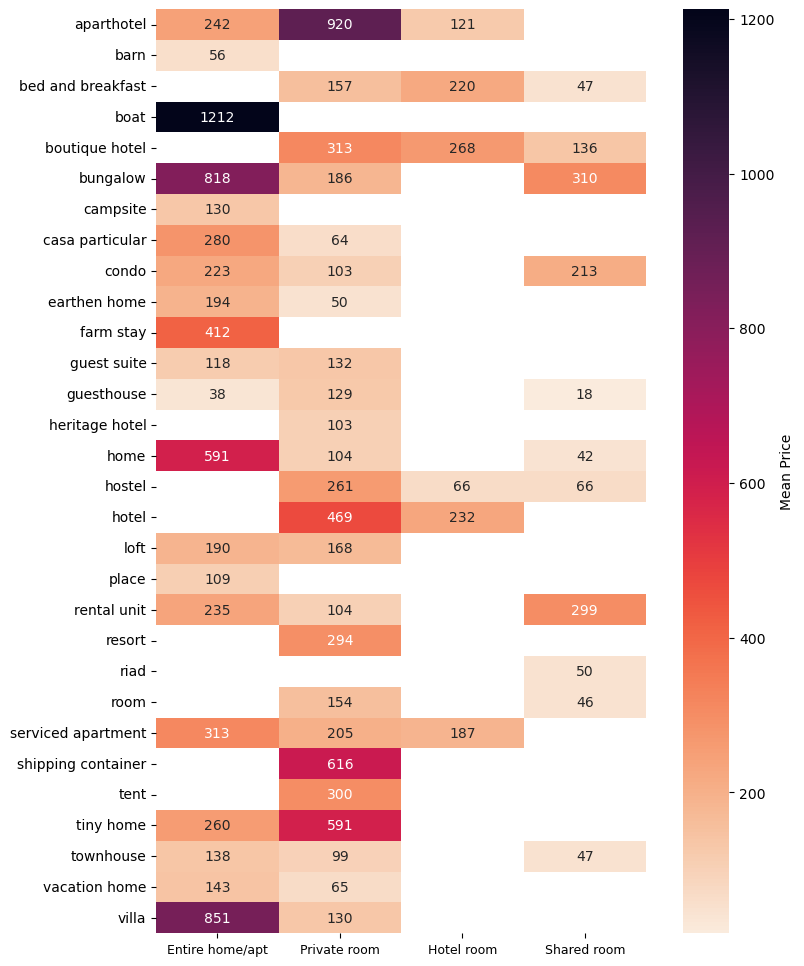

In [219]:
proom_type = df.groupby(['property_type', 'room_type']).price.mean().unstack()
proom_type = proom_type.reindex(columns = ['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'])
plt.figure(figsize = (8,12))
sns.heatmap(proom_type, annot=True, fmt=".0f", cmap = sns.cm.rocket_r, cbar_kws={'label': 'Mean Price', 'orientation': 'vertical','pad':0.06})
plt.xlabel('') 
plt.ylabel('') 
plt.xticks(rotation=0, fontsize='9', horizontalalignment='center')

# Listing Name Word Cloud

In [246]:
def CleanName(line):
    return re.sub('[^A-Za-z]+', ' ', line).lower()

df['clean_name'] = df['name'].apply(CleanName)
df['clean_name'] = df['clean_name'].str.replace('johor bahru', '')
# Let's compare raw and cleaned texts.
df[['name', 'clean_name']].head()

name                       clean_name
0      Pleasant Room along Bukit Timah  pleasant room along bukit timah
1  Ensuite Room (Room 1 & 2) near EXPO      ensuite room room near expo
2      B&B  Room 1 near Airport & EXPO       b b room near airport expo
3           Room 2-near Airport & EXPO           room near airport expo
4    15 mins to Outram MRT Single Room   mins to outram mrt single room

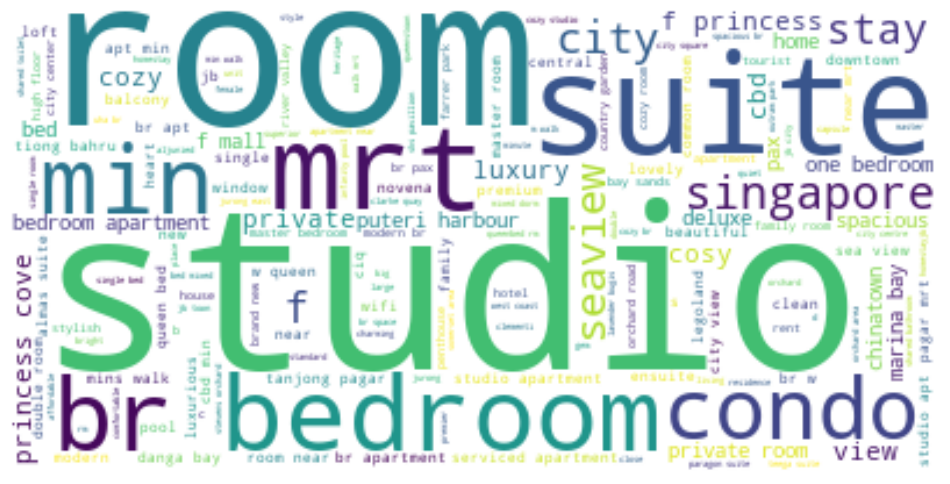

In [248]:
text = ' '.join(str(n).lower() for n in df.clean_name)
#Generate wordcloud image
wordcloud = WordCloud(max_words=200, background_color = 'white').generate(text)
plt.figure(figsize=(12,8))
#Display the image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Host with Most Listings

In [84]:
host_count = df.host_id.value_counts(sort=True).reset_index()
host_count.columns = ['Host ID', 'Number of Listings']
host_count.head(10)


Host ID  Number of Listings
0  138649185                 217
1  156409670                 180
2   66406177                 143
3    2413412                  97
4  238891646                  88
5    8948251                  74
6   97878860                  65
7   41870590                  61
8   23336011                  51
9  219550151                  49

# Calendar Data - Revenue

In [147]:
revenue = pd.DataFrame(df_cal.groupby(['date'])['adjusted_price'].agg(['sum', 'count']))
revenue.reset_index(inplace=True)
revenue

date       sum  count
0   2022-09-22  513212.0   2337
1   2022-09-23  891617.0   4160
2   2022-09-24  904471.0   4160
3   2022-09-25  869212.0   4160
4   2022-09-26  865706.0   4160
..         ...       ...    ...
361 2023-09-18  965670.0   4160
362 2023-09-19  965106.0   4160
363 2023-09-20  965541.0   4160
364 2023-09-21  966525.0   4160
365 2023-09-22  410374.0   1825

[366 rows x 3 columns]

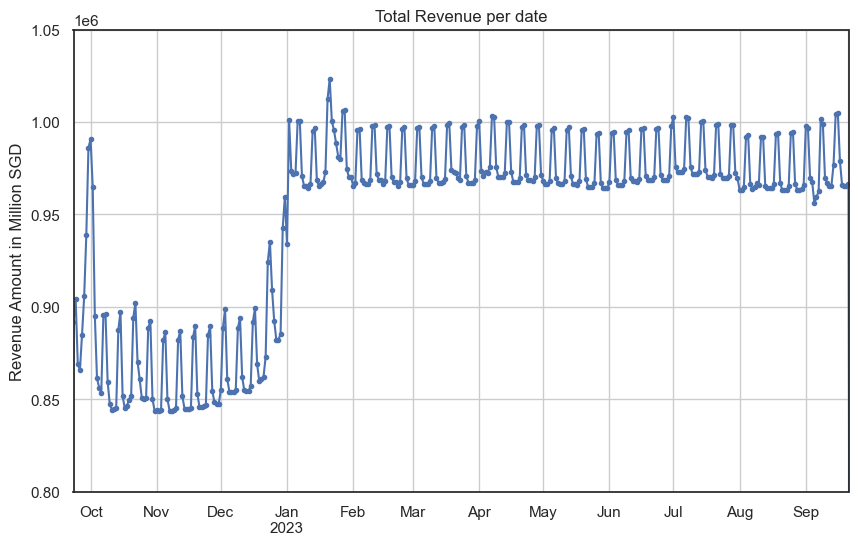

In [259]:
ax = revenue.plot(x='date', y='sum', color='b', marker='.', figsize = (10,6), grid = True)
ax.set_title("Total Revenue per date")
ax.set_xlabel('')
ax.set_ylabel('Revenue Amount in Million SGD')
#ax.yaxis.set_major_formatter(million_formatter)
ax.set_xlim([datetime.date(2022, 9, 23), datetime.date(2023, 9, 21)])
ax.set_ylim(800000,1050000)
ax.get_legend().remove()

# Number of Reviews

In [245]:
reviews = pd.DataFrame(df_rev.groupby(['date'])['id'].agg(['count']))
reviews.reset_index(inplace=True)
reviews

date  count
0    2011-05-04      1
1    2011-05-29      1
2    2011-07-30      1
3    2011-08-04      1
4    2011-08-20      1
...         ...    ...
3182 2022-09-18    114
3183 2022-09-19     44
3184 2022-09-20     20
3185 2022-09-21     25
3186 2022-09-22     15

[3187 rows x 2 columns]

In [268]:
reviews_month = reviews.resample('M', on='date').sum()
reviews_month.reset_index(inplace=True)
reviews_month

date  count
0   2011-05-31      2
1   2011-06-30      0
2   2011-07-31      1
3   2011-08-31      3
4   2011-09-30      2
..         ...    ...
132 2022-05-31   1970
133 2022-06-30   2057
134 2022-07-31   2276
135 2022-08-31   2331
136 2022-09-30   1492

[137 rows x 2 columns]

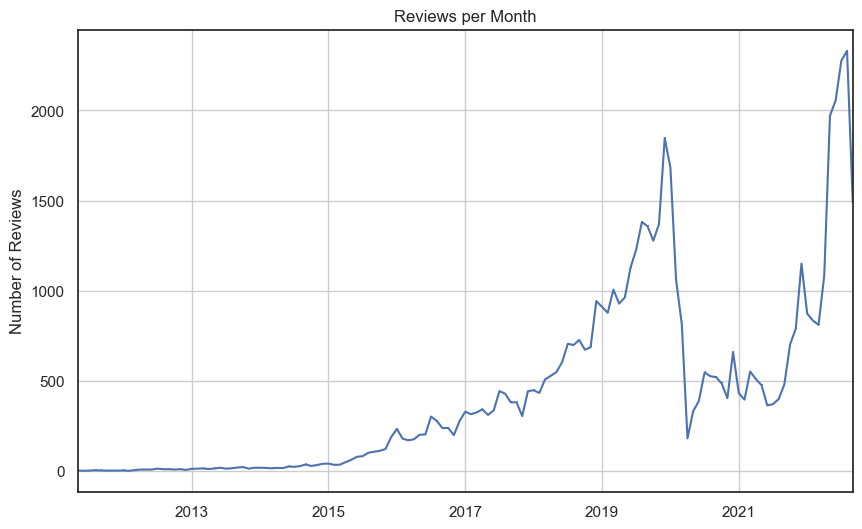

In [258]:
ax = reviews_month.plot(x='date', y='count', color='b', marker=',', figsize = (10,6), grid = True)
ax.set_title("Reviews per Month")
ax.set_xlabel('')
ax.set_ylabel('Number of Reviews')
ax.get_legend().remove()


# Top 100 Listings

In [62]:
df100 = df.nlargest(100, 'number_of_reviews')

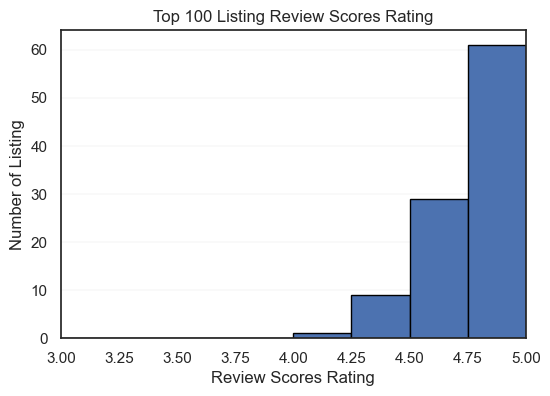

In [74]:
plt.figure(figsize=(6,4))
plt.grid(linewidth=0.15, axis='y')
plt.hist(df100['review_scores_rating'], bins=np.arange(0,5.1,0.25), edgecolor='black')
plt.title('Top 100 Listing Review Scores Rating')
plt.xlabel('Review Scores Rating')
plt.ylabel('Number of Listing')
plt.xlim(3,5) 
#plt.grid(False)
#plt.axvspan(0, 121, color='red', alpha=0.2)
plt.show()

In [70]:
df100["amenities"] = df100["amenities"].apply(eval)

#for i, l in enumerate(df["amenities"]):
#    print('list',i,'is',type(l))

def to_1D(series):
 return pd.Series([x for _list in series for x in _list])
to_1D(df100["amenities"]).value_counts().head(10)

Essentials                 98
Wifi                       97
Hair dryer                 95
Shampoo                    93
Hot water                  91
Iron                       90
Air conditioning           89
Hangers                    88
Long term stays allowed    85
Kitchen                    81
dtype: int64

([], [])

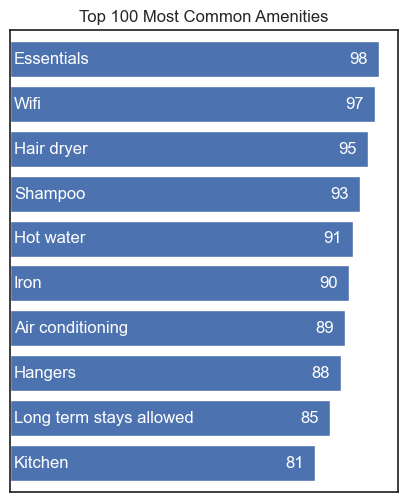

In [75]:
amn100 = to_1D(df100["amenities"]).value_counts().head(10).sort_values(ascending=True)
amn100.plot(kind="barh", width=0.8, figsize=(5,6))
for i, (p, pr) in enumerate(zip(amn100.index, amn100.values)):
    plt.text(s=p, x=1, y=i, color="w", verticalalignment="center", size=12)
    plt.text(s=str(pr), x=pr-3, y=i, color="w",
             verticalalignment="center", horizontalalignment="right", size=12)
    
plt.title('Top 100 Most Common Amenities')
plt.grid(linewidth=0.5, axis='x')
plt.axis()
plt.xlabel('')
plt.ylabel('')
plt.xticks()
plt.yticks([])
plt.xticks([])

### This part is messy

In [ ]:
df100.groupby(['host_is_superhost']).size()

In [ ]:
df100.groupby(['instant_bookable']).size()

In [ ]:
df100.groupby(['host_has_profile_pic']).size()

In [ ]:
df100.groupby(['host_identity_verified']).size()

([], [])

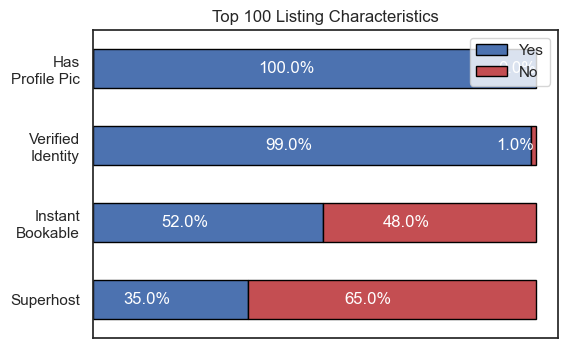

In [80]:
data = {'Name': ['Superhost', 'Instant\nBookable', 'Verified\nIdentity', 'Has\nProfile Pic'],
        'Yes': [35, 52, 99, 100],
        'No': [65, 48, 1, 0]}
char100 = pd.DataFrame(data)

  
# plot a Stacked Bar Chart using matplotlib
char100.plot(figsize=(6,4), edgecolor = "black",
  x = 'Name', 
  kind = 'barh', 
  stacked = True, color=['b','r'],
  title = 'Top 100 Listing Characteristics', 
  mark_right = True)
  
char_total = char100["Yes"] + char100["No"]
char_rel = char100[char100.columns[1:]].div(char_total, 0)*100
  
for n in char_rel:
    for i, (cs, ab, pc) in enumerate(zip(char100.iloc[:, 1:].cumsum(1)[n], 
                                         char100[n], char_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                 va = 'center', ha = 'right', color = 'w')
        
plt.ylabel('')
plt.xticks([])

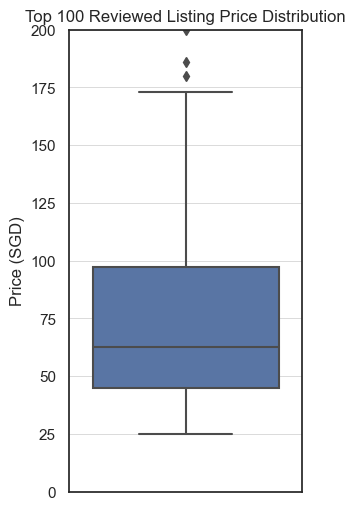

In [68]:
sns.set(rc={"figure.figsize":(3, 6)}) #width=6, height=5
sns.set_style("white")
sns.boxplot(y='price', data = df100, showfliers = True)
plt.title('Top 100 Reviewed Listing Price Distribution')
plt.xlabel('')
plt.ylabel('Price (SGD)')
plt.ylim(0,200)
plt.grid(linewidth=0.5, axis='y')
plt.show()

In [69]:
df100['price'].agg(['count', 'mean', 'median', 'min', 'max'])

count     100.00
mean       96.94
median     62.50
min        25.00
max       819.00
Name: price, dtype: float64

Text(0.5, 1.0, 'Top 100 Region and Room Types')

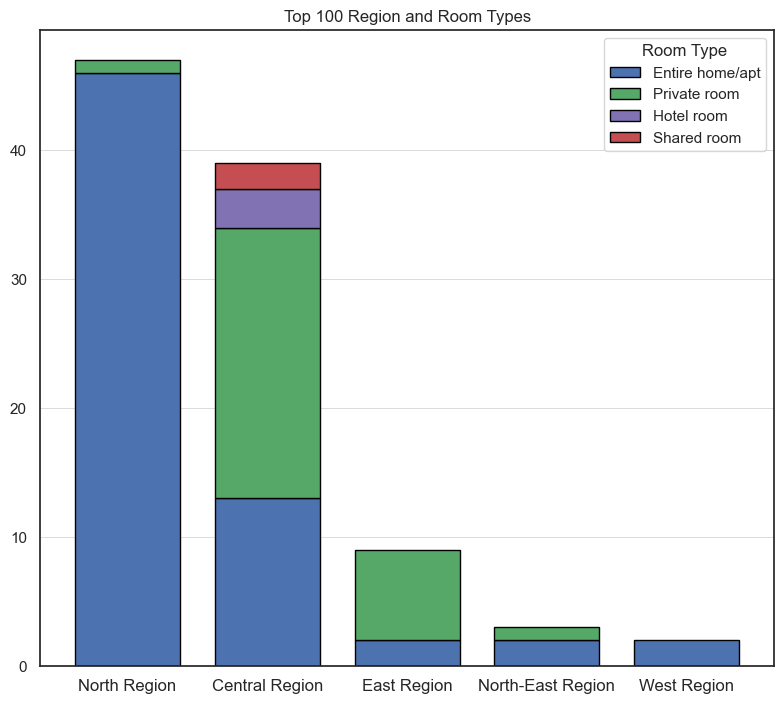

In [72]:
ax = df100.groupby(['neighbourhood_group_cleansed', 'room_type']).size().unstack()
ax = ax.reindex(index =['North Region', 'Central Region', 'East Region', 'North-East Region', 'West Region'])
ax = ax.reindex(columns = ['Entire home/apt', 'Private room', 'Hotel room', 'Shared room'])
ax.plot(kind='bar',figsize=(8,7), stacked=True, color=['b','g','m','r'], width = 0.75, edgecolor = "black")
plt.xticks(rotation=0, fontsize='12', horizontalalignment='center')
plt.xlabel('')
plt.grid(linewidth=0.5, axis='y')
plt.legend(title='Room Type')
plt.tight_layout()
plt.title('Top 100 Region and Room Types')

In [73]:
df100.groupby(['neighbourhood_group_cleansed', 'room_type']).size()

neighbourhood_group_cleansed  room_type      
Central Region                Entire home/apt    13
                              Hotel room          3
                              Private room       21
                              Shared room         2
East Region                   Entire home/apt     2
                              Private room        7
North Region                  Entire home/apt    46
                              Private room        1
North-East Region             Entire home/apt     2
                              Private room        1
West Region                   Entire home/apt     2
dtype: int64